In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import theano 
from scipy.stats import norm
from matplotlib import pyplot as plt

%matplotlib inline

# load data

In [2]:
df = pd.read_csv('pseudonymized-data.csv')
df = df.rename(columns={df.columns[0]: 'id'})
df = df[df["Community"] != "-1"]
df.head()

,id,Community,V27,V28,V29,V30,V31,V32,V33
0,0,Comm.FOSSASIA,4,4,4,5,1,1,1
1,1,Comm.FOSSASIA,5,5,5,5,1,1,1
2,2,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
3,3,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
4,4,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1


In [3]:
df.iloc[:,2:].describe()

,V27,V28,V29,V30,V31,V32,V33
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,1.492754,1.533333,1.440580,1.623188,0.504348,0.344928,0.678261
std,2.648075,2.682776,2.605357,2.763453,1.689781,1.542003,1.864047
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,4.000000,4.000000,4.000000,5.000000,2.000000,1.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


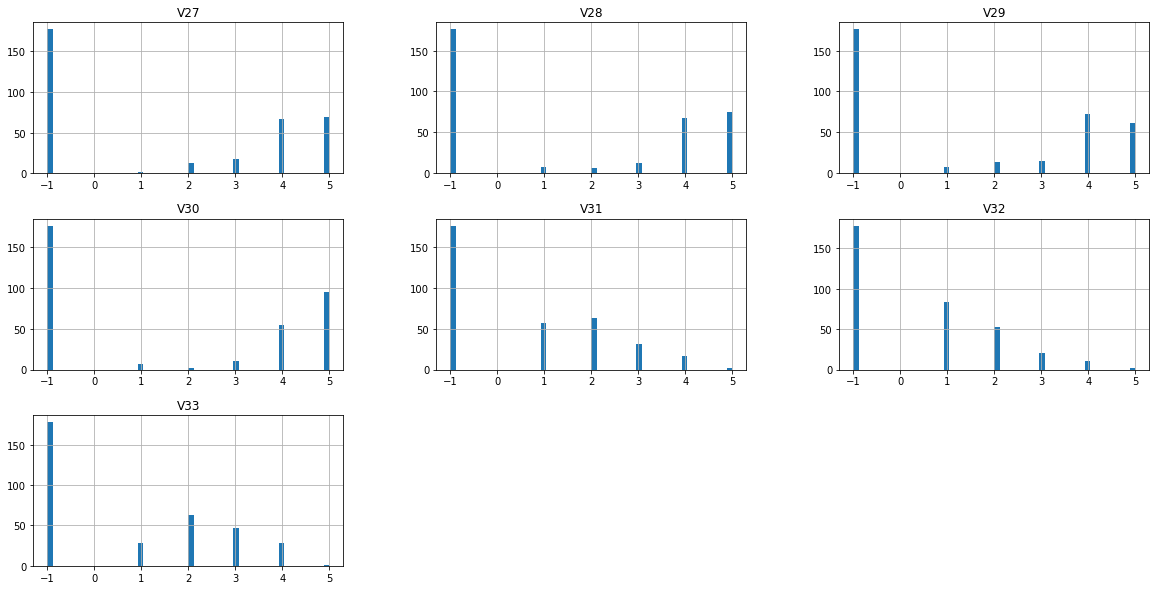

In [4]:
df.hist(column=df.columns[1:], bins=50, figsize=(20,10))
plt.show()

In [5]:
# V27 = df[df.Community == 'Comm.FOSSASIA'].V27.to_numpy()

def removeNoAnswer(lst):
    return [i for i in lst if i!=-1]
#    return lst[np.where(lst != -1)]

data = []
for com in df.Community.unique():
    columns  = []
    for question in df.iloc[:,2:].columns:
        columns.append(removeNoAnswer(df[df.Community == com][question].to_numpy()))
    positive = [[int(d<=3) for d in v] for v in columns]

    N = [len(v) for v in columns]
    μ = [np.mean(v) for v in columns]
    σ = [np.std(v) for v in columns]
    
    N_positive = [len(v) for v in positive]
    μ_positive = [np.mean(v) for v in positive]
    σ_positive = [np.std(v) for v in positive]
    all = (com, columns, positive, N, μ, σ, N_positive, μ_positive, σ_positive)
    data.append(all)

In [6]:
# def standardize(data, m, sd):
#     return (data-m)/sd
# all_z = []
# for i in range(len(answers)):
#     lst=[]
#     for com in range(len(answers[i])):
#         z=standardize(answers[i][com], μ[i][com], σ[i][com])
#         lst.append(z)
#     all_z.append(lst)


### H1
The Coala Community is more lenient than the Linux Kernel Community.

#### Decision Rules - for reference
The basic principle 
 
- Decision Rule 1. If the null value is far from credible values: reject the hypothesis 
- Decision Rule 2. If all credible values are practically equivalent to the null value: accept the hypothesis 
- **Example.** If we want to prove that a coin is biased, we want to reject the null value of 0.5

Null value - draft
- The Likert scale value of Coala community is greater than that of Linux Kernel Community
- The difference is non zero - 95% HDI of difference doesn't overlap with ROPE of zero - (maybe +-.25 of the scale ~0.05%)


In [7]:
h1_diff_rope = 0.25

In [8]:
def getrelevant(com, dataIndex):
    (com, columns, positive, N, μ, σ, N_positive, μ_positive, σ_positive)=next(filter(lambda lst : lst[0]==com, data))

    return (com, columns[dataIndex], positive[dataIndex], N[dataIndex], μ[dataIndex], σ[dataIndex], N_positive[dataIndex], μ_positive[dataIndex], σ_positive[dataIndex])

(com_coala, z_coala, positive_coala, N_coala, μ_coala, σ_coala, N_coala_positive, μ_coala_positive, σ_coala_positive)=getrelevant("Comm.Coala", 6)
(com_linux, z_linux, positive_linux, N_linux, μ_linux, σ_linux, N_linux_positive, μ_linux_positive, σ_linux_positive)=getrelevant("Comm.Linux_Kernel", 6)

print("z: ",z_coala,z_linux)
print("N: ",N_coala,N_linux)
print("μ: ",μ_coala,μ_linux)
print("σ: ",σ_coala,σ_linux)

print("p: ",positive_coala,positive_linux)
print("N: ",N_coala_positive,N_linux_positive)
print("μ: ",μ_coala_positive,μ_linux_positive)
print("σ: ",σ_coala_positive,σ_linux_positive)

z:  [2, 1, 2, 2, 1, 2, 2] [2, 4, 4, 3, 3, 1, 2, 3, 2, 3, 3, 4, 3, 4, 2, 2, 3, 4]
N:  7 18
μ:  1.7142857142857142 2.888888888888889
σ:  0.45175395145262565 0.8748897637790901
p:  [1, 1, 1, 1, 1, 1, 1] [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
N:  7 18
μ:  1.0 0.7222222222222222
σ:  0.0 0.4479032082388083


Model description

In [9]:
def makeModel(observed_coala, observed_linux, obs_μ_coala, obs_μ_linux, obs_σ_coala, obs_σ_linux):
    with pm.Model() as model_h1:
        μ_noData = pm.Normal('μ_noData', mu=1, sigma=100*1, shape=2)
        μ        = pm.Deterministic('μ', μ_noData*[obs_μ_coala, obs_μ_linux])
        σ_noData = pm.Uniform('σ_noData', lower=1/1000, upper=1*1000, shape=2)
        σ        = pm.Deterministic('σ', σ_noData*[obs_σ_coala, obs_σ_linux])
        ν_minus_one = pm.Exponential('ν_minus_one', lam=1/29)
        ν = pm.Deterministic('ν', ν_minus_one+1)

        # for plotting/comparison purposes
        log10_ν = pm.Deterministic('log10_ν',np.log10(ν))
        eff_size = pm.Deterministic('eff_size',(μ-100)/σ)

        #likelihood
        obs_coala   = pm.StudentT('obs_coala',  nu=ν,mu=μ[0],sd=σ[0],observed=observed_coala)
        obs_linux   = pm.StudentT('obs_linux',  nu=ν,mu=μ[1],sd=σ[1],observed=observed_linux)

        #differences
        diff_μ   = pm.Deterministic('diff_μ', μ[0]-μ[1])
        diff_σ   = pm.Deterministic('diff_σ', σ[0]-σ[1])
    return model_h1
        
model_h1_pure    =makeModel(z_coala, z_linux, μ_coala, μ_linux, σ_coala, σ_linux)
model_h1_positive=makeModel(positive_coala, positive_linux, μ_coala_positive, μ_linux_positive, σ_coala_positive, σ_linux_positive)

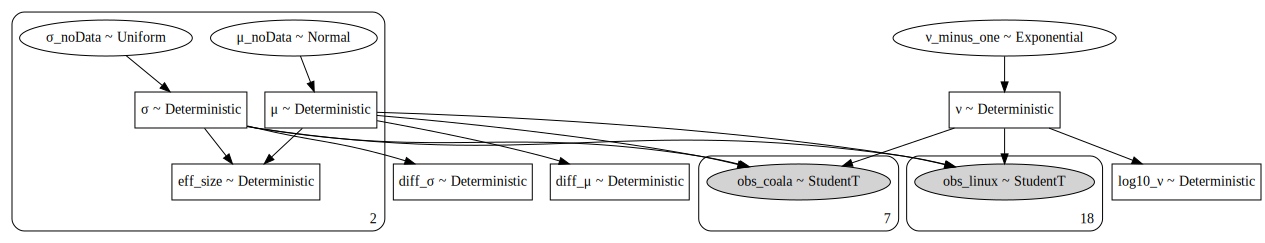

In [10]:
pm.model_to_graphviz(model_h1_pure)

In [11]:
resample=True
def getTrace(folderName, model_h1):
    with model_h1:
        if (resample):
            trace_h1=pm.sample(10000, chains=4, cores=1, step=pm.NUTS())
            pm.save_trace(trace_h1, folderName, overwrite=True)
            
        trace_h1  = pm.load_trace(folderName)
        trace_h1_inferencedata = az.from_pymc3(trace_h1)
    return (trace_h1, trace_h1_inferencedata)

(trace_h1_pure, trace_h1_inferencedata_pure) = getTrace("h1_pure.trace", model_h1_pure)

# The sampler is still giving the error - SamplingError: Bad initial energy
# (trace_h1_positive, trace_h1_inferencedata_positive) = getTrace("h1_positive.trace", model_h1_positive)

Sequential sampling (4 chains in 1 job)
NUTS: [ν_minus_one, σ_noData, μ_noData]
Sampling chain 3, 0 divergences: 100%|█████████████████████████████████████████| 10500/10500 [00:09<00:00, 1143.62it/s]
The acceptance probability does not match the target. It is 0.8786298542446701, but should be close to 0.8. Try to increase the number of tuning steps.


In [12]:
az.summary(trace_h1_pure)

C:\Users\Stha\miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ_noData[0],1.011,0.151,0.721,1.286,0.001,0.001,23681.0,22872.0,27520.0,21094.0,1.0
μ_noData[1],1.003,0.082,0.847,1.154,0.001,0.000,24383.0,24383.0,24732.0,21349.0,1.0
μ[0],1.733,0.259,1.236,2.205,0.002,0.001,23681.0,22872.0,27520.0,21094.0,1.0
μ[1],2.896,0.236,2.446,3.334,0.002,0.001,24383.0,24383.0,24732.0,21349.0,1.0
σ_noData[0],1.352,0.591,0.565,2.373,0.004,0.003,17694.0,17694.0,18159.0,13218.0,1.0
σ_noData[1],1.081,0.219,0.707,1.498,0.001,0.001,26577.0,25410.0,27405.0,23457.0,1.0
σ[0],0.611,0.267,0.255,1.072,0.002,0.001,17694.0,17694.0,18159.0,13218.0,1.0
σ[1],0.945,0.192,0.618,1.310,0.001,0.001,26577.0,25410.0,27405.0,23457.0,1.0
ν_minus_one,35.248,30.227,0.430,89.602,0.160,0.116,35900.0,33664.0,23168.0,11628.0,1.0
ν,36.248,30.227,1.430,90.602,0.160,0.116,35900.0,33719.0,23168.0,11628.0,1.0


In [13]:
# az.summary(trace_h1_positive)

In [14]:
var_names=['log10_ν', 'μ', 'σ', 'diff_σ', 'diff_μ']
def plotMethod1(trace_h1_inferencedata):
    az.plot_posterior(trace_h1_inferencedata, var_names=var_names[:-1], kind='hist', figsize=(8,6)
                      , point_estimate='mean', hdi_prob=0.95);    
    az.plot_posterior(trace_h1_inferencedata, var_names=["diff_μ"], kind='hist', figsize=(8,2.5)
                      , point_estimate='mean', hdi_prob=0.95, ref_val=0, rope=(-h1_diff_rope,+h1_diff_rope));

def plotMethod2(trace_h1, model_h1):
    az.plot_trace(az.from_pymc3(trace_h1,model=model_h1), var_names=var_names);

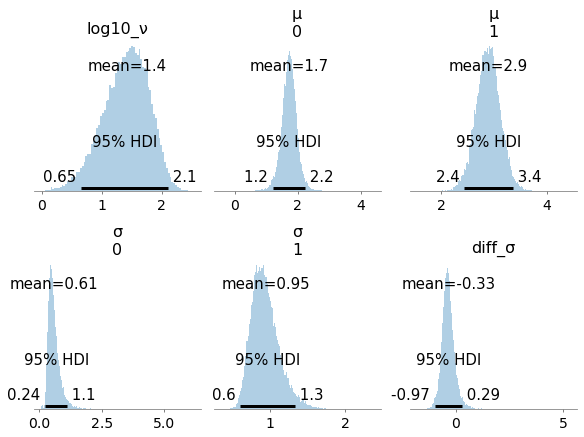

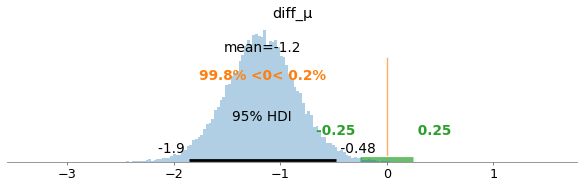

In [15]:
plotMethod1(trace_h1_inferencedata_pure)

In [16]:
# plotMethod1(trace_h1_inferencedata_positive)

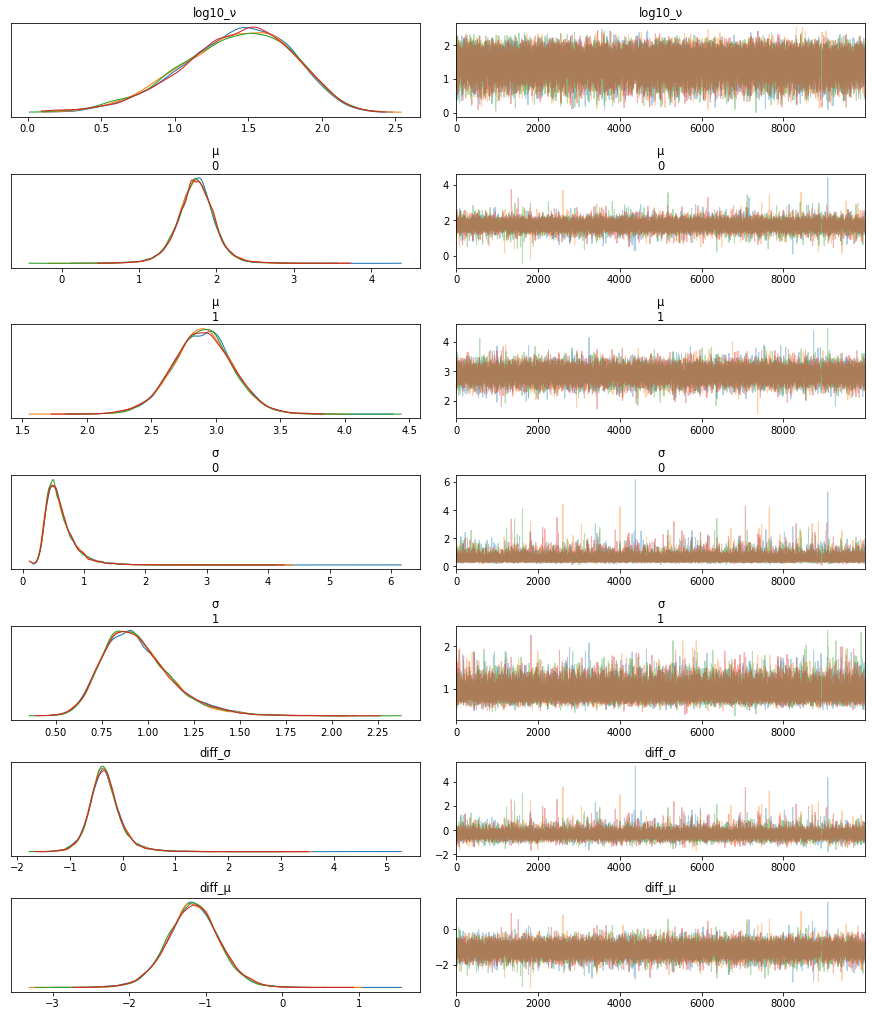

In [17]:
plotMethod2(trace_h1_pure, model_h1_pure)

In [18]:
# plotMethod2(trace_h1_positive, model_h1_positive)